In [16]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import gpytorch

from io import StringIO
from torch.utils.data import Dataset
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline

device = torch.device('cuda')
dtype = torch.float

## Data Info
- **group** : campaing group id
- **item** : id of the advertisement
- **channel** : channel where the id is running
- **date** : date of the stats presented
- **bid** : bid value (per user)
- **budget** : budget value (overall)
- **engagements** : number of engagements during the whole day, given target audience, bids and budgets
- **page_views** : number of page views during the whole day, given target audience, bids and budgets
- **clicks** : number of clicks during the whole day, given target audience, bids and budgets
- **active_days** : days that ad item was active (counting present day)
- **media_spend** : how much spend the item got in this day
- **media_cpc** : ratio of media_spend and clicks
- **cpe** : KPI, the ratio of media_spend / engagements (lower is better)
- **headline** : the title of the ad item
- **storySummary** : the description of the ad item
- **IABCategory** : high-level category of the item
- **targetGeo** : ads will be shown in this geolocation(s)
- **targetInterest** : ads will be shown to users which have these interests
- **targetAge** : ads will be shown to users with this age
- **targetOs** : ads will be shown to users with this OS
- **targetDevices** : ads will be shown to users with these type of devices
- **targetGender** : ads will be shown to users with this gender
- **targetLanguages** : ads will be shown to users with these languages
- **CATEGORY_1** : detailed category of the content being promoted

## 1. Load Data

In [2]:
# Load data
df = pd.read_csv('../data/problem_merged_data.csv', parse_dates=['date'])

df.rename(columns={
    'IABCategory': 'content_category',
    'CATEGORY_1': 'content_sub_category',
    'storySummary': 'story_summary',
    'targetGeo': 'target_geo',
    'targetInterest': 'target_interest',
    'targetAge': 'target_age',
    'targetOs': 'target_os',
    'targetDevices': 'target_devices',
    'targetGender': 'target_gender',
    'targetLanguages': 'target_languages'
}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1682 entries, 0 to 1681
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   group                 1682 non-null   int64         
 1   item                  1682 non-null   int64         
 2   channel               1682 non-null   object        
 3   date                  1682 non-null   datetime64[ns]
 4   bid                   1682 non-null   float64       
 5   budget                1682 non-null   float64       
 6   engagements           1682 non-null   int64         
 7   page_views            1682 non-null   int64         
 8   clicks                1682 non-null   int64         
 9   active_days           1682 non-null   int64         
 10  media_spend           1682 non-null   float64       
 11  media_cpc             1682 non-null   float64       
 12  cpe                   1682 non-null   float64       
 13  headline          

## 2. Some visualizations

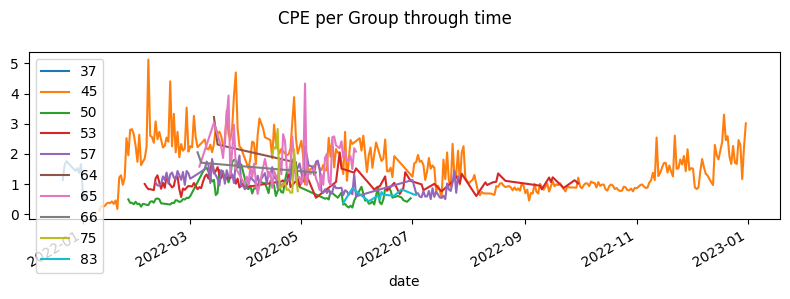

In [3]:
grouping = df.groupby(['date', 'group'])[['cpe']]\
    .mean()\
    .reset_index()\
    .set_index('date')\
    .groupby('group')

fig, ax = plt.subplots(figsize=[8, 3])
for group, df_temp in grouping:
    df_temp['cpe'].plot(ax=ax, label=str(group))

ax.legend(loc='best')
fig.suptitle('CPE per Group through time')
fig.tight_layout()
plt.show()

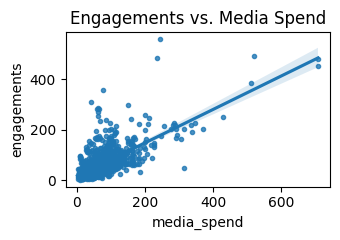

In [4]:
plt.figure(figsize=[3.5, 2.5])
sns.regplot(data=df, x='media_spend', y='engagements', marker='.')
plt.title('Engagements vs. Media Spend')
plt.tight_layout()
plt.show()

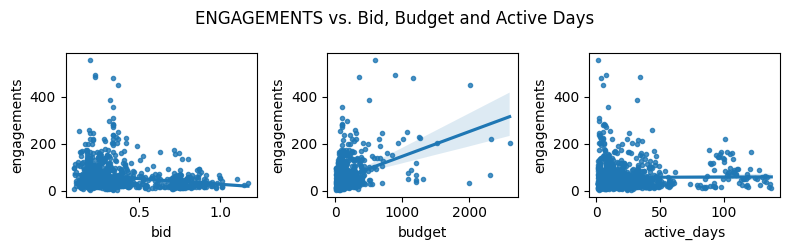

In [5]:
def regplot(df, base_col):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=[8, 2.5])
    sns.regplot(data=df, x='bid', y=base_col, marker='.', ax=ax1)
    sns.regplot(data=df, x='budget', y=base_col, marker='.', ax=ax2)
    sns.regplot(data=df, x='active_days', y=base_col, marker='.', ax=ax3)
    fig.suptitle(f'{base_col.upper()} vs. Bid, Budget and Active Days')
    fig.tight_layout()
    plt.show()

regplot(df.query('channel == "YAHOO"'), 'engagements')

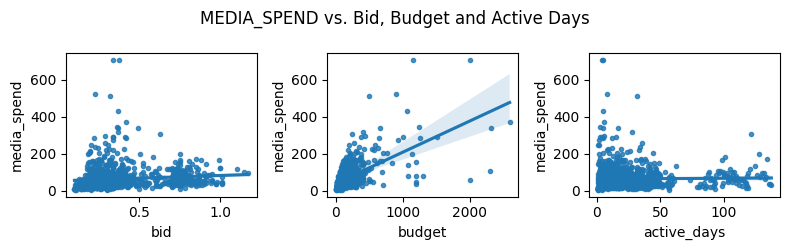

In [6]:
regplot(df.query('channel == "YAHOO"'), 'media_spend')

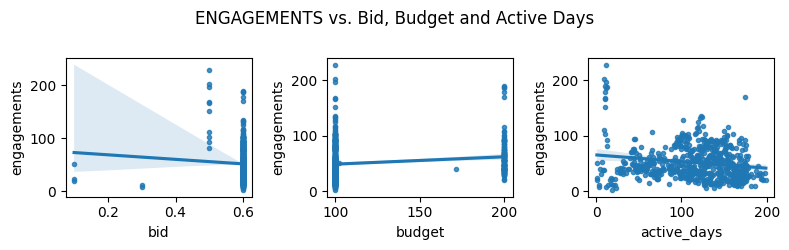

In [10]:
regplot(df.query('channel == "REVCONTENT"'), 'engagements')

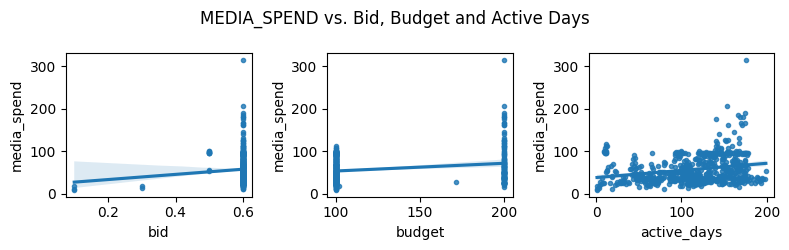

In [11]:
regplot(df.query('channel == "REVCONTENT"'), 'media_spend')

## 3. Feature Engineering
#### Some notes:
1. The features *Headline*, *Story Summary*, *Target Interest* (name and description) and *Target Geolocation* are all treated as tokens, which are processed and stemmized.
2. The targets, *Media Spend* and *Engagements*, are transformed using a $\log$ function.

In [12]:
def tokenize_and_stemmize(text):
    stop_words = stopwords.words('english')
    stemmer = SnowballStemmer('english')
    return ' '.join([
        stemmer.stem(word.lower())
        for word in word_tokenize(text)
        if word.isalnum() and (word not in stop_words)
    ])

def create_geolocation_features(text):
    keys, values = [], []
    for geo in text.strip(';').split(';'):
        geo = json.load(StringIO(geo))
        for k, v in geo.items():
            if (k not in ('channelId', 'channelName')) and (not v.isdigit()):
                keys.append(str(k).lower())
                values.append(str(v).lower().split(',')[0].replace(' ', ''))
    return ' '.join([v for v in np.unique(values) if v.isalnum()])

class TextVectorizer(BaseEstimator, TransformerMixin):
    def __init__(
        self,
        base_vectorizer: BaseEstimator=TfidfVectorizer(),
        headline: bool=False,
        story_summary: bool=False,
        interest: bool=False,
        geolocation: bool=False
    ):
        super().__init__()
        self.base_vectorizer = base_vectorizer
        self.headline = headline
        self.story_summary = story_summary
        self.interest = interest
        self.geolocation = geolocation

    def build_features(self, df: pd.DataFrame):
        def get_interest_text(x):
            if not pd.isnull(x):
                data = json.load(StringIO(x.strip(';')))
                return data['interestName'] + ' ' + data['interestDescription']
            return ''

        text_features = ''
        if self.headline:
            text_features += df['headline'] + ' '
        if self.story_summary:
            text_features += df['story_summary'] + ' '
        if self.interest:
            text_features += df['target_interest'].apply(get_interest_text)
        if len(text_features) > 0:
            text_features = text_features.apply(tokenize_and_stemmize)
        if self.geolocation:
            text_features += ' ' + df['target_geo'].apply(create_geolocation_features)

        return text_features

    def fit(self, df: pd.DataFrame, y=None):
        self.base_vectorizer.fit(self.build_features(df))
        return self

    def transform(self, df: pd.DataFrame, y=None):
        x = self.base_vectorizer.transform(self.build_features(df)).toarray()
        return x

### 3.1 Define the Features Pipeline

In [17]:
numerical_cols = [
    'bid',
    'budget',
    'active_days'
]
categorical_cols = [
    'item',
    'group',
    'channel',
    'target_age',
    'target_os',
    'target_gender',
    'content_category',
    'content_sub_category'
]
text_cols = [
    'headline',
    'story_summary',
    'target_interest',
    'target_geo'
]
target_cols = [
    'media_spend',
    'engagements'
]

# Define the transformers
numerical_transformer = make_pipeline(FunctionTransformer(np.log, np.exp), StandardScaler())
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
text_transformer = TextVectorizer(
    base_vectorizer=TfidfVectorizer(smooth_idf=True),
    headline=True,
    story_summary=True,
    interest=True,
    geolocation=True
)

# Define the Inputs and Targets pipeline
inputs_pipeline = ColumnTransformer(
    transformers=[
        ('numerical', numerical_transformer, numerical_cols),
        ('categorical', categorical_transformer, categorical_cols),
        ('text', text_transformer, text_cols)
    ]
)
targets_pipeline = FunctionTransformer(np.log, np.exp)
inputs_pipeline

ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<ufunc 'log'>,
                                                                      inverse_func=<ufunc 'exp'>)),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['bid', 'budget', 'active_days']),
                                ('categorical',
                                 OneHotEncoder(handle_unknown='ignore',
                                               sparse_output=False),
                                 ['item', 'group', 'channel', 'target_age',
                                  'target_os', 'target_gender',
                                  'content_category', 'content_sub_category']),
                                ('text',
                                 TextVectorizer(geolocation=True, headline=True,
                                                interest=True,
                                                story_summary=True),
                                 ['headline', 'story_summary',
                                  'target_interest', 'target_geo'])])

In [18]:
# Transform the Inputs and Targets
x = torch.tensor(inputs_pipeline.fit_transform(df), dtype=dtype)
y = torch.tensor(targets_pipeline.fit_transform(df[target_cols].values), dtype=dtype)
print(f'# Features: {x.size(1)}')

# Features: 1019


## 4. The Strategy
The strategy is straightforward: one model for predicting the *Media Spend* and another model for predicting the number of *Engagements*. Both models are choosen to be a Gaussian Process (GP). After both models are trained, the Bid and Budget values are optimized through a brute-force algorithm.

### 4.1 Gaussian Process and the predictive distribution
A GP is defined as distribution over function, $f : \mathcal{X}\rightarrow\mathbb{R}$, where $f = [f(x_i)]_{i=1}^N$, which follows a multivariate normal distribution $f\sim\mathcal{N}(\mu, K_f)$, where $\mu$ is the mean function and $K_f$ is a kernel matrix computed over $X$. Following a Bayesian approach, the predictive expression of a GP is also a Gaussian distribution.

In this task, since the $\log (\mathrm{MediaSpend})$ and $\log(\mathrm{Engagements})$ are beign modeled, they are assumed to the normally distributed. In order to recober the original values, one has to apply the $\exp$ function. Because both $\log(\mathrm{MediaSpend})$ an $\log(\mathrm{Engagements})$ follows a Gaussian distribution, applying the $\exp$ function results in a LogNormal distribution for the original MediaSpend and Engagements values, so that
$$
\begin{aligned}
    \mathrm{Engagments} &\sim \mathrm{LogNormal}(\mu_e, \sigma_e^2)\\
    \mathrm{MediaSpend} &\sim \mathrm{LogNormal}(\mu_{ms}, \sigma_{ms}^2).
\end{aligned}
$$

### 4.2 Define the GP model and the Dataset

In [19]:
class GaussianProcess(gpytorch.models.ExactGP):
    def __init__(self, x_train, y_train):
        likelihood = gpytorch.likelihoods.GaussianLikelihood()
        likelihood.initialize(noise=y_train.var() * 0.1)
        
        super().__init__(x_train, y_train, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = data_covar_module=gpytorch.kernels.ScaleKernel(
            base_kernel=gpytorch.kernels.RBFKernel(ard_num_dims=x_train.size(1))
        )

    def forward(self, x):
        function_dist = gpytorch.distributions.MultivariateNormal(
            mean=self.mean_module(x),
            covariance_matrix=self.covar_module(x)
        )
        return function_dist

    @torch.no_grad()
    def predict(self, x: torch.Tensor) -> torch.distributions.MultivariateNormal:
        self.eval()
        with gpytorch.settings.fast_pred_var():
            targets_dist = self.likelihood(self(x))
        return targets_dist

class BaseDataset(Dataset):
    def __init__(self, inputs, targets, inputs_transformer=None):
        self.inputs = inputs
        self.targets = targets
        self.inputs_transformer = inputs_transformer

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

In [21]:
media_spend_dataset = BaseDataset(x, y[:, 0], inputs_pipeline)
engagements_dataset = BaseDataset(x, y[:, 1], inputs_pipeline)

media_spend_model = GaussianProcess(
    x_train=media_spend_dataset.inputs,
    y_train=media_spend_dataset.targets
).to(device)
engagements_model = GaussianProcess(
    x_train=engagements_dataset.inputs,
    y_train=engagements_dataset.targets
).to(device)

### 4.3 Train and save the MediaSpendModel and the EngagementsModel

In [22]:
def train(model, dataset, epochs=2000, lr=0.03):
    criterion = gpytorch.mlls.ExactMarginalLogLikelihood(model.likelihood, model)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-5)
    
    def train_one_epoch():
        model.train()
        function_dist = model(model.train_inputs[0])
        mll = criterion(function_dist, model.train_targets)
        optimizer.zero_grad()
        (-mll).backward()
        optimizer.step()
        scheduler.step()
        return mll.item()
    
    train_curve = []
    for i in range(epochs):
        train_curve.append(train_one_epoch())
        print(f'Epoch {i}: loss={train_curve[-1]:.4f}')

    return train_curve

In [24]:
media_spend_mll = train(media_spend_model, media_spend_dataset)
engagements_mll = train(engagements_model, engagements_dataset)

os.makedirs('../models/', exist_ok=True)
torch.save(media_spend_model.state_dict(), '../models/media_spend_model.pt')
torch.save(engagements_model.state_dict(), '../models/engagements_model.pt')

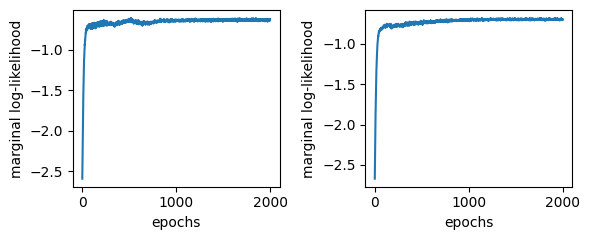

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[6, 2.5])
ax1.plot(media_spend_mll)
ax2.plot(engagements_mll)
ax1.set_ylabel('marginal log-likelihood')
ax1.set_xlabel('epochs')
ax2.set_ylabel('marginal log-likelihood')
ax2.set_xlabel('epochs')
fig.tight_layout()
plt.show()

### 4.4 Load the trained models and evaluate the Mean Absolute Error

In [26]:
media_spend_model.load_state_dict(torch.load('../models/media_spend_model.pt'))
engagements_model.load_state_dict(torch.load('../models/engagements_model.pt'))

<All keys matched successfully>

In [29]:
from torchmetrics.regression import MeanAbsoluteError

media_spend_model.to('cpu')
engagements_model.to('cpu')

def predict(model, inputs):
    targets_dist = model.predict(inputs)
    targets_dist = torch.distributions.LogNormal(targets_dist.mean, targets_dist.stddev)
    return targets_dist

mae_score = MeanAbsoluteError()
media_spend_dist = predict(media_spend_model, media_spend_dataset.inputs)
engagements_dist = predict(engagements_model, engagements_dataset.inputs)

media_spend_mae = mae_score(media_spend_dist.mean, media_spend_dataset.targets.exp())
engagements_mae = mae_score(engagements_dist.mean, engagements_dataset.targets.exp())

print(f'MAE (Media Spend): {media_spend_mae:.2f}\nMAE (Engagements): {engagements_mae:.2f}')

MAE (Media Spend): 10.97
MAE (Engagements): 13.27


## 5. Bid and Budget Optimization

In [112]:
def get_bid_and_budget_grid(x):
    bid_space = np.linspace(x[:, 0].min(), x[:, 1].max(), 200)
    budget_space = np.linspace(x[:, 1].min(), x[:, 1].max(), 200)
    bid_grid, budget_grid = np.meshgrid(bid_space, budget_space)
    bid_and_budget_grid = torch.tensor(np.c_[bid_grid.ravel(), budget_grid.ravel()], dtype=dtype)
    return bid_and_budget_grid

def optimize_bid_and_budget(x, bid_and_budget_grid):
    x = x.clone()
    x = x.tile(len(bid_and_budget_grid), 1)
    x[:, :2] = bid_and_budget_grid

    # Recover Bid and Budget
    bid_and_budget = torch.tensor(
        inputs_pipeline\
        .named_transformers_['numerical']\
        .inverse_transform(x[:, :3])[:, :2]
    ).type(dtype)
    bid, budget = bid_and_budget[:, 0], bid_and_budget[:, 1]
    
    # Compute the Media Spend and the Engagements distribution
    media_spend_dist = predict(media_spend_model, x)
    engagements_dist = predict(engagements_model, x)
    
    # Compute CEP
    cpe = media_spend_dist.mean / engagements_dist.mean
    
    # Ensure that the Budget is at least the expected Media Spend
    mask_lower_budget = budget < media_spend_dist.mean
    cpe[mask_lower_budget] = torch.inf
    
    ith_min = cpe.argmin()
    return {
        'media_spend': media_spend_dist.mean[ith_min].item(),
        'engagements': engagements_dist.mean[ith_min].round().item(),
        'bid': bid[ith_min].item(),
        'budget': budget[ith_min].item(),
        'cpe': cpe[ith_min].item()
    }

# Select each item
df_items = df\
    .sort_values(['item', 'active_days'])\
    .drop_duplicates(subset=categorical_cols + text_cols, keep='last')\
    [numerical_cols + categorical_cols + text_cols + target_cols + ['cpe']]\
    .reset_index(drop=True)

# Sum 1 into the Active Days (the prediction goes for the next active day)
df_items['active_days'] += 1

# Apply the features pipeline
x_test = torch.tensor(
    media_spend_dataset.inputs_transformer.transform(df_items)
).type(dtype)

# Get optimized Bids and Budgets for each item at active_days+1
bid_and_budget_grid = get_bid_and_budget_grid(x)
optimized_bids_and_budgets = [
    optimize_bid_and_budget(xi, bid_and_budget_grid)
    for xi in x_test
]

In [108]:
df_bids_and_budgets = pd.DataFrame(optimized_bids_and_budgets)
df_bids_and_budgets.index = df_items['item']
df_bids_and_budgets.to_csv('../data/optimized_bids_and_budgets.csv')

In [143]:
df_bids_and_budgets = pd.read_csv('../data/optimized_bids_and_budgets.csv', index_col=0)

total_opt_budget = df_bids_and_budgets['engagements'].sum()
total_budget = df_items['engagements'].sum()

print(f'Past Bid: {df_items.bid.mean():.4f} +/- {df_items.bid.std():.4f}')
print(f'Past Budget: {df_items.budget.mean():.4f} +/- {df_items.budget.std():.4f}')
print(f'Past CPE: {df_items.cpe.mean():.4f} +/- {df_bids_and_budgets.cpe.std():.4f}')
print(f'Past Media Spend: {df_items.media_spend.sum():.2f}')
print(f'Past Engagements: {df_items.engagements.sum()}\n')

print(f'Optimized Bid: {df_bids_and_budgets.bid.mean():.4f} +/- {df_bids_and_budgets.bid.std():.4f}')
print(f'Optimized Budget: {df_bids_and_budgets.budget.mean():.4f} +/- {df_bids_and_budgets.budget.std():.4f}')
print(f'Optimized CPE: {df_bids_and_budgets.cpe.mean():.4f} +/- {df_bids_and_budgets.cpe.std():.4f}')
print(f'Optimized Total Media Spend: {df_bids_and_budgets.media_spend.sum():.2f}')
print(f'Optimized Total Engagements: {df_bids_and_budgets.engagements.sum()}')

Past Bid: 0.3715 +/- 0.2149
Past Budget: 154.8796 +/- 305.9940
Past CPE: 1.5978 +/- 0.2978
Past Media Spend: 8302.34
Past Engagements: 5859

Optimized Bid: 0.4560 +/- 0.7667
Optimized Budget: 670.7820 +/- 766.5987
Optimized CPE: 0.6580 +/- 0.2978
Optimized Total Media Spend: 7853.14
Optimized Total Engagements: 14270.0
